# Codes for Efficient Transmission of Data

## Introduction 

When sending packets of data over a communication channel such as the internet or a radio channel, packets often get erased. Because of this, packets must be sent under some erasure code such that the data can still be recovered. In CS 70, you may have learned about an erasure code that involves embedding the data in a polynomial, and then sampling points from that polynomial. There, we assumed that there were at most $k$ erasures in the channel. This week, we'll explore a different channel model in which each packet independently has a probability $p$ of being erased. In particular, this lab will look at random bipartite graphs (the balls and bins model).

A little more on the channel and the erasure code; formally, our channel is called the binary erasure channel (BEC), where bits that are sent through a noisy channel either make it through unmodified or are tagged as "corrupt", in which case the received information is dropped in all further information processing steps. Here's an image that shows what happens:

<center><img src="https://upload.wikimedia.org/wikipedia/commons/thumb/b/b6/Binary_erasure_channel.svg/156px-Binary_erasure_channel.svg.png"></center>

If we wanted to convey a message, we could consider a feedback channel in which the receiver tells the sender which messages were received and the sender re-sends the dropped packets. This process can be repeated until the receiver gets all of the intended message. While this procedure is indeed optimal in all senses of the word, feedback is simply not possible in many circumstances. If Netflix is trying to stream a show chunked into $n$ data chunks to a million people, its servers can't process all the feedback from the users. Thus, Netflix must use a method independent of feedback. If they use near-optimal codes to encode and constantly send out the same random chunks of the video's data to all users, then they can be sure that users get what they need in only a little more than $n$ transmissions *no matter what parts of the show each individual user lost through their specific channel*!

So what's the secret to this magic?  It's a two step process of clever encoding and decoding:

### Encoding
1. Suppose your data can be divided into $n$ chunks. First, pick an integer $d$ ($1 \leq d \leq n$) according to some distribution.
2. With $d$ picked, now select $d$ random chunks of the data and combine their binary representations together using the XOR operator.
3. Transmit these chunks, along with the metadata telling which actual chunk indices were XOR'd, as a packet. If a packet is erased, both the chunks it contains and the chunk indices would be lost. 

### Decoding
1. For each packet that has been received, check if it only contains one chunk, in which case the packet is exactly equal to the single chunk it contains. If not, we can check if any of the chunks in the packet are already known, in which case XOR that chunk with the packet and remove it from the list of chunk indices that make up the packet.
3. If there are two or more indices in the list left for the packet, we cannot figure out any more information!  Put it on the side for looking at later.
4. With any newly decoded information, we may be able to decode previously undecodable packets that we had put on the side.  Go through all unsolved packets and try to decode more packets until nothing more can be done.
5. Wait for the next packet to come and repeat!

Now what's left for you to do?  Well, remember that number $d$?  It needs to be picked according to some distribution, and which distribution is the million dollar question!


### Example
<center><img src="bipartite.png" style="width: 300px;"> </center>

Consider the above bipartite graph. Here, the right square nodes represent the packets, and the left circular nodes represent the data chunks ($X_i, i=1,..,4$). There is an edge from a packet to a chunk if the packet contains that chunk. Let's try decoding the packets chronologically.
1. Since the first packet contains only the third data chunk, we are able to immediately resolve it and find that $X_3=1$.
2. The second packet contains the second and third chunks XOR'd together. Since we already know the third chunk, we can XOR the third chunk ($X_3=1$) with the data packet (0) to get the value of the second data chunk, $X_2=1$.
3. The third packet contains the XOR of data chunks 1, 2, and 4. We have already determined chunks 2 and 3, so we are able to XOR 2 from this packet, but are still left with 1 and 4, and so must move on.
4. With the arrival of the fourth packet, we are able to resolve everything: data chunks 2 and 3 are already determined, and so we are able to XOR chunk 3 ($X_3=1$) with this new data packet (1) to get the value of the chunk 4, $X_4=0$. With this new information, we are able to resolve $X_1$, as packet 3 gave us the equation $1 = X_1 \oplus X_2 \oplus X_4 = X_1 \oplus 1 \oplus 0$. We can solve this to get $X_1 = 0$.
5. We have now solved for all the data chunks, with $X_1 = 0, X_2 = 1, X_3 = 1, X_4 = 0$.

As you might be able to tell, by choosing a good degree distribution for $d$, even when random incoming packets were lost (not shown), you were still able to recover all $4$ symbols only from $4$ received packets, despite the sender not knowing what packets you lost through the BEC.

## Q1. Code

We've provided you with some starter code, including a Packet class, a Transmitter class, a Channel class, and a Receiver class. **Your job is to complete the receive_packet() function in the Receiver class**. Feel free to write any additional functions that you may need.

### Packet Class & Utility functions

A packet consists of...
- chunk_indices: Which chunks are chosen
- data: The 'XOR'ed data

In [21]:
%matplotlib inline  
import matplotlib.pyplot as plt
import numpy as np
import json
import random

class Packet:
    size_of_packet = 256
    def __init__(self, chunks, chunk_indices):
        self.data = self.xor(chunks)
        self.chunk_indices = chunk_indices

    def xor(self, chunks):
        tmp = np.zeros(Packet.size_of_packet, 'uint8')
        for each_chunk in chunks:
            tmp = np.bitwise_xor(tmp, each_chunk)
        return tmp
            
    def num_of_chunks(self):
        return len(self.chunk_indices)

### Transmitter & Encoder Class

You can initiate an encoder with a string! Then, <tt>generate_packet()</tt> will return a randomly encoded packet.

In [60]:
class Transmitter:
    def __init__(self, chunks, channel, degree_distribution):
        self.chunks = chunks
        self.num_chunks = len(chunks)
        self.channel = channel
        self.degree_distribution = degree_distribution
        
    def generate_new_packet(self, num_sent=None):
        if self.degree_distribution == 'single':
            # Always give a degree of 1
            n_of_chunks = 1
        elif self.degree_distribution == 'double':
            # Always give a degree of 2
            n_of_chunks = 2
        elif self.degree_distribution == 'mixed':
            # Give a degree of 1 half the time, 2 the other half
            if random.random() < 0.5:
                n_of_chunks = 1
            else:
                n_of_chunks = 2
        elif self.degree_distribution == 'baseline':
            """
            Randomly assign a degree from between 1 and 5.
            If num_chunks < 5, randomly assign a degree from 
            between 1 and num_chunks
            """
            n_of_chunks = random.randint(1,min(5, self.num_chunks))
        elif self.degree_distribution == 'sd':
            # Soliton distribution
            tmp = random.random()
            n_of_chunks = -1
            for i in range(2, self.num_chunks + 1):
                if tmp > 1/np.double(i):
                    n_of_chunks = int(np.ceil(1/tmp))
                    break
            if n_of_chunks == -1:
                n_of_chunks = 1
        elif self.degree_distribution == 'competition':
            # BEGIN YOUR SOLUTION (Question 4)
            if num_sent < self.num_chunks:
                n_of_chunks = 1
            else:
                # Soliton distribution
                tmp = random.random()
                n_of_chunks = -1
                for i in range(2, self.num_chunks + 1):
                    if tmp > 1/np.double(i):
                        n_of_chunks = int(np.ceil(1/tmp))
                        break
                if n_of_chunks == -1:
                    n_of_chunks = 1
            # END YOUR SOLUTION
        chunk_indices = random.sample(range(self.num_chunks), n_of_chunks)
        chunks = [ self.chunks[x] for x in chunk_indices ]
        return Packet( chunks, chunk_indices )
        
    def transmit_one_packet(self, num_sent=None):
        packet = self.generate_new_packet(num_sent)
        self.channel.enqueue( packet )

### Channel Class

Channel class takes a packet and erase it with probability eps.

In [15]:
class Channel:
    def __init__(self, eps):
        self.eps = eps
        self.current_packet = None
        
    def enqueue(self, packet):
        if random.random() < self.eps:
            self.current_packet = None
        else:
            self.current_packet = packet
            
    def dequeue(self):
        return self.current_packet

### Receiver & Decoder Class

You can initiate a decoder with the total number of chunks. Then, <tt>add_packet()</tt> will add a received packet to the decoder.

In [40]:
class Receiver:
    def __init__(self, num_chunks, channel):
        self.num_chunks = num_chunks
        
        # List of packets to process.
        self.received_packets = []
        
        # List of decoded chunks, where self.chunks[i] is the original chunk x_i.
        self.chunks = np.zeros((num_chunks, Packet.size_of_packet),dtype=np.uint8)
        
        # Boolean array to keep track of which packets have been found, where self.found[i] indicates
        # if x_i has been found.
        self.found = [ False for x in range(self.num_chunks) ]
        self.channel = channel
        
    def process_received_packet(self):
        flag = True
        while flag:
            flag = False
            for packet in self.received_packets:
                if packet.num_of_chunks() == 1: # Found a singleton
                    flag = True
                    idx = packet.chunk_indices[0] 
                    break
            # First, declare the identified chunk
            if not self.found[ idx ]:
                self.chunks[ idx ] = np.array(packet.data, 'uint8') 
                self.found[ idx ] = True
            # Second, peel it off from others
            for packet in self.received_packets: 
                if idx in packet.chunk_indices:
                    packet.chunk_indices.remove( idx )
                    packet.data = np.bitwise_xor(packet.data, self.chunks[idx])    

    def receive_packet(self):
        packet = self.channel.dequeue()
        if packet is not None:
            self.received_packets.append( packet ) 
            chunk_indices_iter = list(packet.chunk_indices) 
            for chunk_idx in chunk_indices_iter:
                if self.found[chunk_idx]:
                    packet.chunk_indices.remove( chunk_idx ) 
                    packet.data = np.bitwise_xor(packet.data, self.chunks[chunk_idx])
            if packet.num_of_chunks() == 1: 
                self.process_received_packet()
            
            
    def isDone(self):
        return self.chunksDone() == self.num_chunks

    def chunksDone(self):
        return sum(self.found)

## Q2. Sending the raccoon

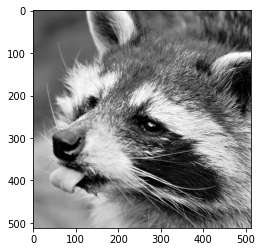

In [41]:
from scipy import misc
import matplotlib.cm as cm

# pip3 install pillow
from PIL import Image
import numpy as np
l = np.asarray(plt.imread("raccoon.jpg"))
# converts the image to grayscale
x = np.zeros((512,512),dtype=np.uint8)
for i in range(512):
    for j in range(512):
        x[i][j] = l[i][j][0]*0.299+l[i][j][1]*0.587+l[i][j][2]*0.113

plt.imshow(x, cmap = cm.Greys_r)

**a. Break up the image shown below into $1024$ chunks of size $256$ each.** Hint: You should only need one line for this part.

In [42]:
tt = x.reshape(1,512*512)[0]
size_of_packet = 256 
num_of_packets = 1024
assert len(tt) == size_of_packet * num_of_packets

# BEGIN YOUR SOLUTION
chunks = [tt[i*256:(i+1)*256] for i in range(1024)]
# END YOUR SOLUTION

Here's a function that simulates the transmission of data across the channel. It returns a tuple containing the total number of packets sent, the intermediate image every 512 packets and the final image, and the number of chunks decoded every 64 packets). You'll use it for the next question.

In [43]:
# Returns a tuple (packets sent, intermediate image every 512 packets + final image, chunks decoded every 64 packets)
def send(tx, rx, verbose=False):
    threshold = rx.num_chunks * 20
    num_sent = 0
    images = []
    chunks_decoded = []
    while not rx.isDone():
        tx.transmit_one_packet(num_sent)
        rx.receive_packet()
        if num_sent % 512 == 0:
            images.append(np.array(rx.chunks.reshape((512,512))))
            if verbose:
                print(num_sent, rx.chunksDone())
        if num_sent % 64 == 0:
            chunks_decoded.append(rx.chunksDone())
        num_sent += 1
        if num_sent > threshold:
            print("Ending transmission because too many packets have been sent. This may be caused by a bug in " + 
                  "receive_packet or an inefficient custom strategy.")
            break
            
    chunks_decoded.append(rx.chunksDone())
    images.append(rx.chunks.reshape((512,512)))
    return (num_sent, images, chunks_decoded)

**b. Using the 'single' degree distribution defined in the Transmitter class, send the raccoon over a channel with erasure probability 0.2.**  How many packets did you need to send?

The number of packets sent: 9326


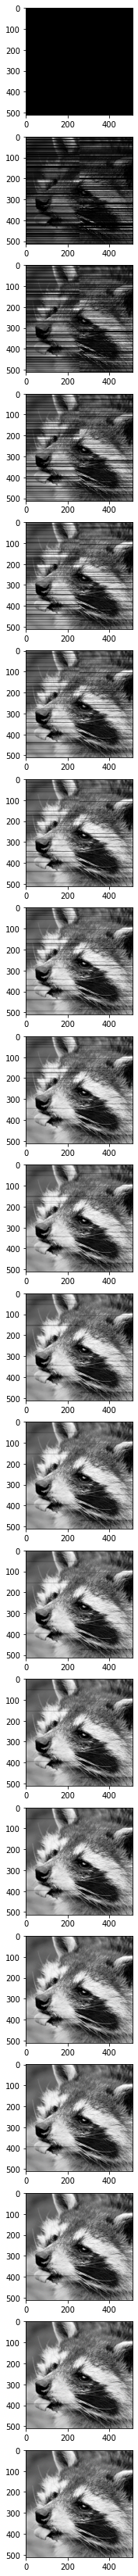

In [44]:
# BEGIN YOUR SOLUTION
# Set the below values to setup the channel
eps = 0.2
ch = Channel(eps)
tx = Transmitter(chunks, ch, "single")
rx = Receiver(len(chunks), ch)
# END YOUR SOLUTION

single_sent, images, single_decoded = send(tx,rx)

print("The number of packets sent: {}".format(single_sent))

n_of_figures = len(images)
fig = plt.figure(figsize=(8, 3*n_of_figures))

for i in range(n_of_figures):
    fig.add_subplot(n_of_figures,1,i+1)
    plt.imshow(images[i], cmap = cm.Greys_r)

**c. Plot the number of chunks decoded as a function of the number of packets you send. (The chunks_decoded array should be helpful here)**

Text(0, 0.5, 'number of chunks decoded')

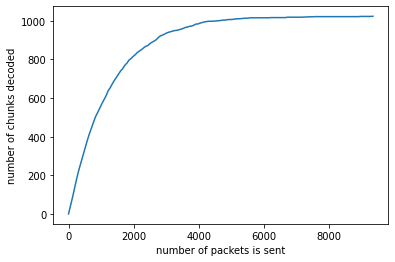

In [46]:
# BEGIN YOUR SOLUTION
plt.plot(np.arange(0, len(single_decoded) * 64, 64), single_decoded)
plt.xlabel("number of packets is sent")
plt.ylabel("number of chunks decoded")
# END YOUR SOLUTION

**d. Looking at the graph, we see that it gets harder and harder to find the rest as we decode more and more chunks. Does this remind you of a well known theoretical problem?**

Weapon Collection Problem

**e. Using the 'double' degree distribution defined in the Transmitter class, send the raccoon over a channel with erasure probability 0.2. Don't worry about intermediate plots this time. What happens?**

In [47]:
# BEGIN YOUR SOLUTION
eps = 0.2
ch = Channel(eps)
tx = Transmitter(chunks, ch, "double")
rx = Receiver(len(chunks), ch)
# END YOUR SOLUTION

double_sent, images, double_decoded = send(tx,rx)
print("The number of packets sent: {}".format(double_sent))

Ending transmission because too many packets have been sent. This may be caused by a bug in receive_packet or an inefficient custom strategy.
The number of packets sent: 20481


YOUR ANSWER HERE

## Q3. Randomized Distributions

**a. You have seen two degree distributions so far.  Both of these have been deterministic, and one worked better than the other.  Let's try a different degree distribution.  Using the 'baseline' degree distribution, send the raccoon over a channel with erasure probability 0.2 over multiple trials. For each trial, record the number of packets sent for the image to be decoded. Then, plot this as a histogram.**

(array([ 8., 21., 22., 15., 20.,  6.,  4.,  0.,  2.,  2.]),
 array([2180. , 2484.6, 2789.2, 3093.8, 3398.4, 3703. , 4007.6, 4312.2,
        4616.8, 4921.4, 5226. ]),
 <BarContainer object of 10 artists>)

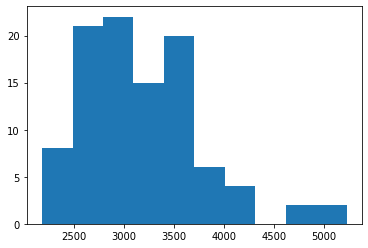

In [48]:
num_trials = 100  # do not change this
# BEGIN YOUR SOLUTION
eps = 0.2
ch = Channel(eps)
tx = Transmitter(chunks, ch, "baseline")
# END YOUR SOLUTION

packets_required = []

for _ in range(num_trials):
    rx = Receiver(len(chunks), ch)
    # BEGIN YOUR SOLUTION
    baseline_sent, _, _ = send(tx,rx)
    packets_required.append(baseline_sent)
    # END YOUR SOLUTION
    
# Plot the packets required as a histogram
# BEGIN YOUR SOLUTION
plt.hist(packets_required)
# END YOUR SOLUTION

**b. Let's examine one final degree distribution. Using the 'sd' degree distribution, send the image over a channel with erasure probability 0.2. Plot the number of packets decoded against the number of packets transmitted.**

The number of packets sent: 1864


Text(0, 0.5, 'number of chunks decoded')

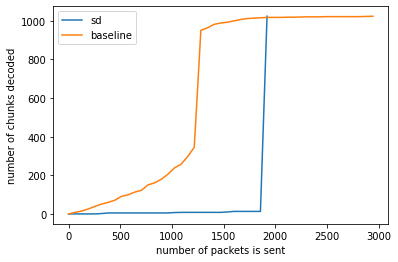

In [54]:
# BEGIN YOUR SOLUTION
eps = 0.2
ch = Channel(eps)
tx1 = Transmitter(chunks, ch, "baseline")
tx2 = Transmitter(chunks, ch, "sd")
rx1 = Receiver(len(chunks), ch)
rx2 = Receiver(len(chunks), ch)
baseline_sent, images, baseline_decoded = send(tx1,rx1)
sd_sent, images, sd_decoded = send(tx2,rx2)
print("The number of packets sent: {}".format(sd_sent))
plt.plot(np.arange(0, sd_sent + 64, 64), sd_decoded, label="sd")
plt.plot(np.arange(0, baseline_sent + 64, 64), baseline_decoded, label="baseline")
plt.legend()
plt.xlabel("number of packets is sent")
plt.ylabel("number of chunks decoded")
# END YOUR SOLUTION

## Q4. Competition Model

Alice has just finished eating dinner, and with her EECS 126 homework completed early for once, she plans to sit down for a movie night (she wants to make use of the 30-day free trial of Netflix!).  While Alice is surfing Netflix she decides she wants to stream Interstellar. Alice's laptop drops packets with $p=0.2$.  You, the Chief Technology Officer of Netflix, know that given the heavy workload of EECS 126, this may be your only chance to convert this freeloading customer into a permanent one, but to do so you're going to have to make sure her viewing experience is perfect.

### Concrete specs:

- You are given an erasure channel with drop probability $p=0.2$.
- You must define a degree distribution (which can vary as a function of the # of transmissions already sent) to minimize the number of total packets needed to be sent for the raccoon to be decoded.  Run your code for 10 trials to get a good estimate of the true number of transmissions needed per image while they watch their movies.  Each trial, your score is 

$$\frac{\text{# of packets successfully decoded from the first 512 packets}}{512}+\frac{\text{# of packets successfully decoded from the first 1024 packets}}{1024}+\lfloor\frac{\text{# of packets successfully decoded from the first 2048 packets}}{1024}\rfloor+\lfloor\frac{\text{# of packets successfully decoded from the first 4096 packets}}{1024}\rfloor+\lfloor\frac{\text{# of packets successfully decoded from the first 6144 packets}}{1024}\rfloor$$

- Note the floor function in the later stages - you can only get the point if you fully decode the file with the alloted number of packets

- In order to receive full credit for this question, you must receive a score of >= 3
- **You may work in teams of up to three.**
- Hint: you can use the num_sent argument of Transmitter if you want


Good luck! 

*If you place in the top 3 teams in the class you will receive extra credit!*

*Note that we will be rerunning solutions, so do not cheat.*

In [56]:
from math import floor

def score(chunks_decoded):
    c_d = chunks_decoded
    s = c_d[8]/512+c_d[16]/1024
    arr = [33,65,97]
    for i in arr:
        if i >= len(c_d):
            s += 1
    return s

In [61]:
trials = 10  
s, avg = 0, 0
eps = 0.2
ch = Channel(eps)
tx = Transmitter(chunks, ch, "competition")

for _ in range(trials):
    rx = Receiver(len(chunks), ch)
    comp_sent, _, comp_decoded = send(tx,rx)
    s += score(comp_decoded)
    avg += comp_sent
print("Score: {}".format(s/trials)) 
print("Sent: {}".format(avg/trials))

Score: 3.30966796875
Sent: 2221.2


### Results

- **Report the average score (averaged over 100 trials)**: SCORE
- **Report the names of your teammates**: TEAMMATES

## References
[1] D. Mackay.  Information Theory, Inference, and Learning Algorithms. 2003 <br>
[2] http://blog.notdot.net/2012/01/Damn-Cool-Algorithms-Fountain-Codes